In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")


Notebook last run (end-to-end): 2024-08-09 22:53:38.258654


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-08-09 22:53:38.710693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1723254818.731494   10281 cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1723254818.739857   10281 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 22:53:38.758935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 22:53:40.165135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3568931456606801674
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3140288512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1233551557973709593
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


I0000 00:00:1723254821.282637   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723254821.327733   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723254821.327975   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
W0000 00:00:1723254821.328078   10281 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel bin

### Basic regression: Predict fuel efficiency 

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras tutorials and guides to learn more.)

- source - https://www.tensorflow.org/tutorials/keras/regression



In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)

2.18.0-dev20240722


### The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/)

### Get the data

First download and import the dataset using pandas:

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Shape Dataset

In [7]:
dataset.shape

(398, 8)

### Clean the data

The dataset contains a few unknown values:

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [9]:
dataset = dataset.dropna()

In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [12]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

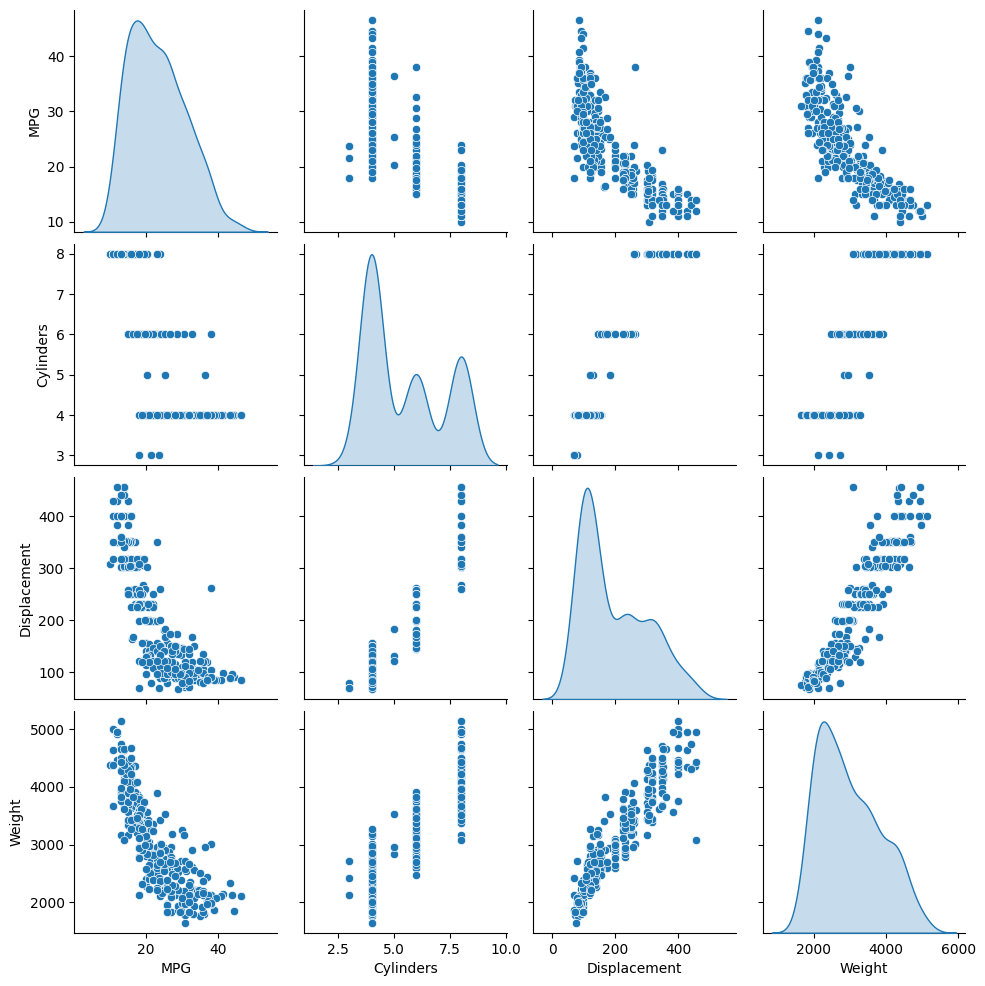

In [14]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [15]:
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-08-09 22:53:48.917430


### Normalization

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [17]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin,1.573248,0.800988


### The Normalization layer

In [18]:
train_dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [20]:
normalizer.adapt(np.array(train_features))

I0000 00:00:1723254829.054333   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723254829.054614   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723254829.057948   10281 cuda_executor.cc:809] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
W0000 00:00:1723254829.058071   10281 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel bin

In [21]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    1.573]]


In [22]:
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-08-09 22:53:49.217667


In [23]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

2024-08-09 22:53:49.250573: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_NO_BINARY_FOR_GPU'

2024-08-09 22:53:49.250607: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2024-08-09 22:53:49.250622: W tensorflow/core/framework/op_kernel.cc:1828] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2024-08-09 22:53:49.250647: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'


First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]



InternalError: Exception encountered when calling Normalization.call().

[1m{{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Sub] name: [0m

Arguments received by Normalization.call():
  • inputs=tf.Tensor(shape=(1, 7), dtype=float32)

In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/home/andvsilva/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [ ]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


array([[ 0.782],
       [ 0.442],
       [-1.443],
       [ 1.096],
       [ 0.991],
       [ 0.389],
       [ 1.174],
       [ 0.991],
       [ 0.258],
       [ 0.442]], dtype=float32)

In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.69 s, sys: 427 ms, total: 5.12 s
Wall time: 8.63 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803868,4.162042,95
96,3.808030,4.153078,96
97,3.805550,4.165863,97
98,3.804850,4.209188,98
99,3.803686,4.195153,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

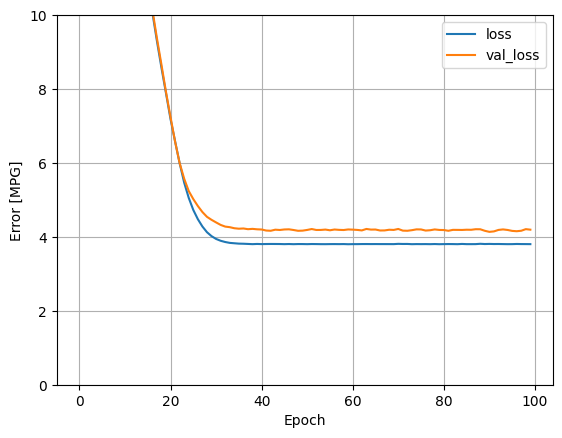

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

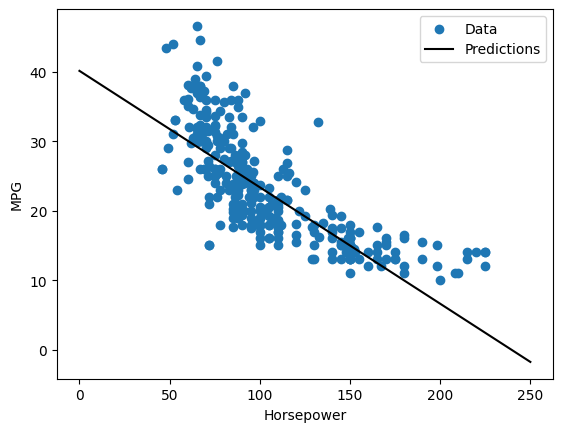

In [ ]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


array([[-0.2  ],
       [-0.116],
       [ 1.707],
       [ 0.656],
       [-1.879],
       [ 0.33 ],
       [-2.201],
       [-1.848],
       [ 0.031],
       [-2.92 ]], dtype=float32)

In [ ]:
linear_model.layers[1].kernel

<KerasVariable shape=(7, 1), dtype=float32, path=sequential_1/dense_1/kernel>

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.67 s, sys: 387 ms, total: 5.06 s
Wall time: 8.87 s


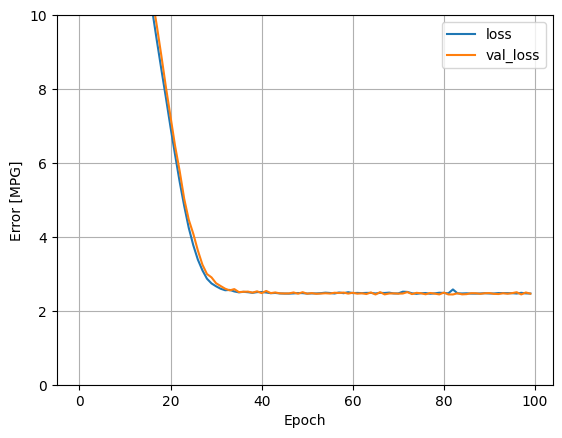

In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [ ]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.2 s, sys: 336 ms, total: 5.54 s
Wall time: 7.8 s


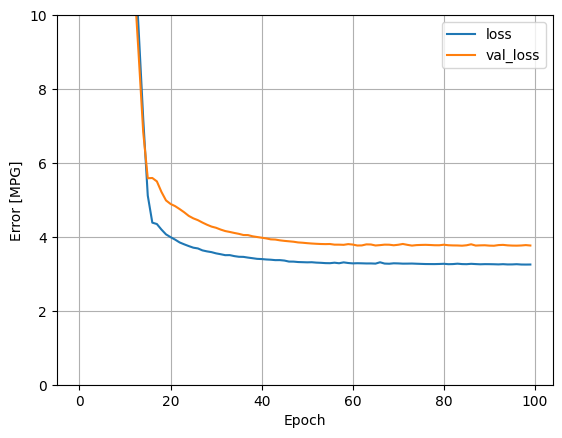

In [ ]:
plot_loss(history)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f49f5f731c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


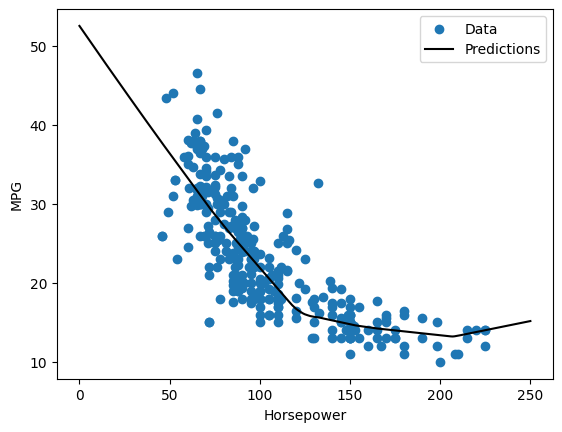

In [ ]:
plot_horsepower(x, y)

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 7)                │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (64.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15 (64.00 B)

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.44 s, sys: 463 ms, total: 5.91 s
Wall time: 9.19 s


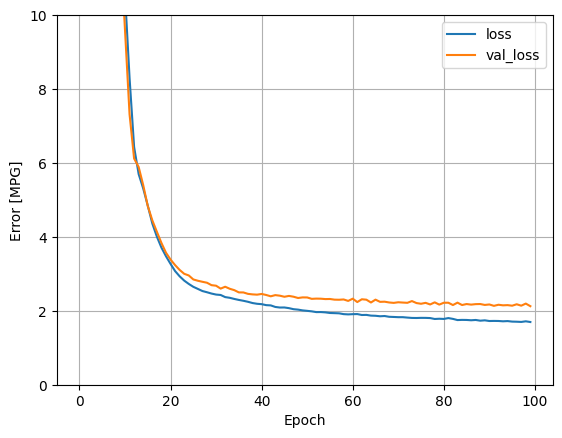

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652078
linear_model,2.437735
dnn_horsepower_model,2.922527
dnn_model,1.795579


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


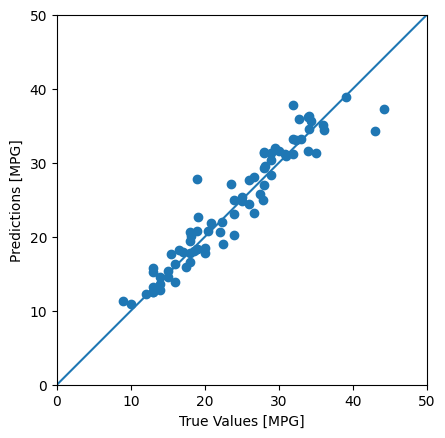

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

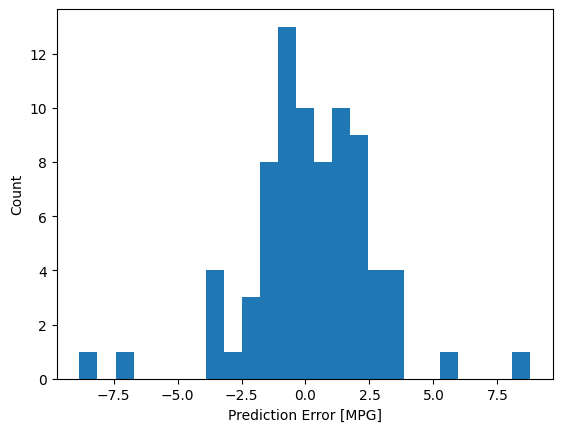

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
###################################

### Generate dataset to world around with deep learning.

- How we can build a model and improve it.

In [ ]:
import random
from scipy import stats

In [ ]:
n = 80
X = []
y = []

limit = 0.2

for i in range(0, n):
    errx = round(random.uniform(0, limit), 2)
    X.append(i+errx)

    erry = round(random.uniform(0, limit), 2)
    y.append(2 * i + erry)

X_train = np.array(X)
y_train = np.array(y)

X_train, y_train

(array([ 0.04,  1.02,  2.12,  3.12,  4.04,  5.07,  6.06,  7.08,  8.14,
         9.07, 10.07, 11.09, 12.  , 13.14, 14.05, 15.14, 16.01, 17.16,
        18.09, 19.09, 20.01, 21.02, 22.17, 23.1 , 24.19, 25.04, 26.16,
        27.19, 28.13, 29.09, 30.08, 31.15, 32.18, 33.12, 34.03, 35.15,
        36.1 , 37.05, 38.12, 39.04, 40.  , 41.17, 42.18, 43.1 , 44.03,
        45.18, 46.15, 47.01, 48.2 , 49.12, 50.16, 51.15, 52.  , 53.01,
        54.06, 55.19, 56.13, 57.02, 58.16, 59.  , 60.02, 61.09, 62.11,
        63.18, 64.06, 65.06, 66.07, 67.14, 68.03, 69.09, 70.05, 71.  ,
        72.11, 73.16, 74.09, 75.04, 76.01, 77.18, 78.08, 79.07]),
 array([  0.17,   2.05,   4.06,   6.2 ,   8.13,  10.11,  12.18,  14.11,
         16.17,  18.11,  20.17,  22.04,  24.14,  26.1 ,  28.12,  30.15,
         32.18,  34.13,  36.15,  38.07,  40.18,  42.02,  44.08,  46.06,
         48.11,  50.05,  52.15,  54.09,  56.16,  58.07,  60.09,  62.04,
         64.18,  66.12,  68.16,  70.18,  72.12,  74.16,  76.16,  78.18,
      

In [ ]:
n = 100
X = []
y = []

for i in range(80, n):
    errx = round(random.uniform(0, limit), 2)
    X.append(i+errx)

    erry = round(random.uniform(0, limit), 2)
    y.append(2 * i + erry)

X_test = np.array(X)
y_test = np.array(y)

X_test , y_test 

(array([80.15, 81.  , 82.04, 83.16, 84.04, 85.01, 86.13, 87.13, 88.06,
        89.05, 90.12, 91.1 , 92.09, 93.11, 94.1 , 95.03, 96.05, 97.16,
        98.12, 99.16]),
 array([160.12, 162.07, 164.2 , 166.16, 168.01, 170.18, 172.16, 174.04,
        176.03, 178.17, 180.01, 182.08, 184.  , 186.14, 188.02, 190.19,
        192.12, 194.05, 196.13, 198.1 ]))

In [ ]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)

In [ ]:
# Creating a DataFrame with two columns: 'X' for features and 'y' for the target variable
df = pd.DataFrame({'X': X, 'y': y})

print("DataFrame with two columns (X and y):")
print(df)

DataFrame with two columns (X and y):
        X       y
0   80.15  160.12
1   81.00  162.07
2   82.04  164.20
3   83.16  166.16
4   84.04  168.01
5   85.01  170.18
6   86.13  172.16
7   87.13  174.04
8   88.06  176.03
9   89.05  178.17
10  90.12  180.01
11  91.10  182.08
12  92.09  184.00
13  93.11  186.14
14  94.10  188.02
15  95.03  190.19
16  96.05  192.12
17  97.16  194.05
18  98.12  196.13
19  99.16  198.10


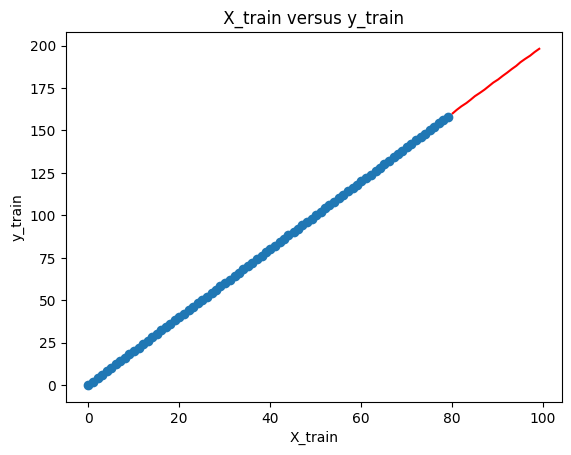

In [ ]:
plt.scatter(X_train, y_train)
plt.xlabel('X_train')
plt.ylabel('y_train')
plt.title(' X_train versus y_train ')
plt.plot(X, y, linestyle='-', color='r')  # '-' for solid line style
plt.show()

In [ ]:
#Set random seed 
tf.random.set_seed(42) 

# Create a model (same as above) 
model = tf.keras.Sequential([ tf.keras.layers.Dense(1) ]) 

# Compile model (same as above) 
model.compile(loss=tf.keras.losses.mae, 
              optimizer=tf.keras.optimizers.SGD(), 
              metrics=["mae"]) 

# Fit model (this time we'll train for longer) 
model.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=50) # train for 100 epochs not 10

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 110.6901 - mae: 110.6901  
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64.5331 - mae: 64.5331 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7475 - mae: 18.7475 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 11.4965 - mae: 11.4965
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8402 - mae: 6.8402 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1157 - mae: 7.1157 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8542 - mae: 6.8542 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1016 - mae: 7.1016 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8683 - mae: 6.8683 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0941 - mae: 7.0941 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8683 - mae: 6.8683 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0941 - mae: 7.0941 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (20.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

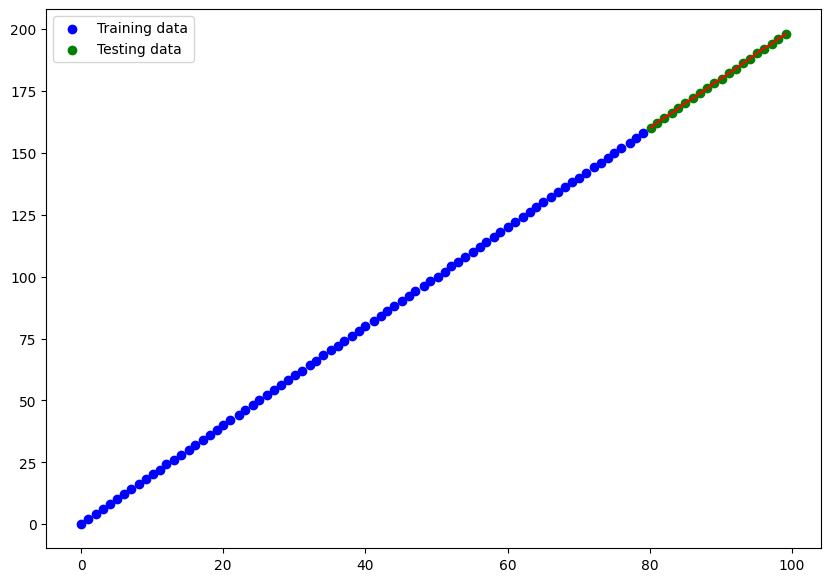

In [ ]:
plt.figure(figsize=(10, 7)) 

# Plot training data in blue 
plt.scatter(X_train, y_train, c='b', label='Training data') 

# Plot test data in green 
plt.scatter(X_test, y_test, c='g', label='Testing data') 

plt.plot(X, y, linestyle='-', color='r')  # '-' for solid line style

# Show the legend 
plt.legend();

In [ ]:
# Make predictions 
y_preds = model.predict(X_test)
y_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[144.926],
       [146.462],
       [148.341],
       [150.366],
       [151.956],
       [153.709],
       [155.733],
       [157.54 ],
       [159.221],
       [161.01 ],
       [162.944],
       [164.715],
       [166.504],
       [168.347],
       [170.136],
       [171.817],
       [173.66 ],
       [175.666],
       [177.401],
       [179.281]], dtype=float32)

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,5)}, font_scale=1.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.4', 'font.family':'Times New Roman'})

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=y_preds): 
    """ Plots training data, test data and compares predictions. """ 

    plt.figure(figsize=(10, 7)) 
    
    # Plot training data in blue 
    plt.scatter(train_data, train_labels, c="b", label="Training data")
     
    # Plot test data in green 
    plt.scatter(test_data, test_labels, c="g", label="Testing data") 
    
    # Plot the predictions in red (predictions were made on the test data) 
    plt.scatter(test_data, predictions, c="r", label="Predictions") 
    
    # Show the legend 
    plt.legend();

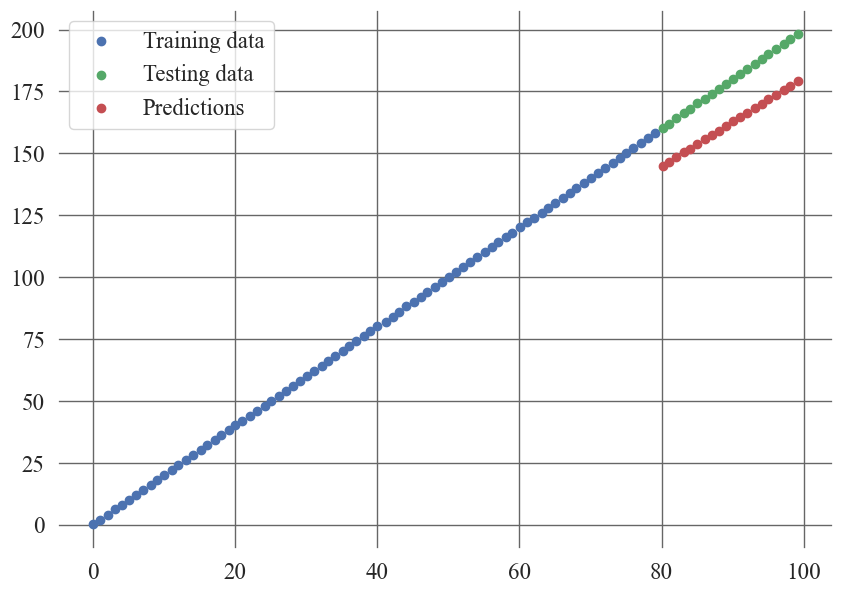

In [ ]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 17.1122 - mae: 17.1122


[17.112241744995117, 17.112241744995117]

## Running experiments to improve a model

- model_1 - same as original model, 1 layer, trained for 100 epochs.

In [ ]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate original model 
model_1 = tf.keras.Sequential([ tf.keras.layers.Dense(1),
                                tf.keras.layers.Input((128, None, 6)) ]) 



In [ ]:
# Compile the model 
model_1.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

In [ ]:
# Fit the model 
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100


ValueError: Layers added to a Sequential model can only have a single positional argument, the input tensor. Layer InputLayer has multiple positional arguments: []

In [ ]:
# Make and plot predictions for model_1 
y_preds_1 = model_1.predict(X_test) 

plot_predictions(predictions=y_preds_1)

: 

- ```Build model_2```: This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [ ]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate model_1 and add an extra layer 
model_2 = tf.keras.Sequential([ tf.keras.layers.Dense(1), 
                               tf.keras.layers.Dense(1) # add a second layer 
                               ]) 

# Compile the model 
model_2.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

# Fit the model 
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100, verbose=0) # set verbose to 0 for less output

: 

In [ ]:
# Make and plot predictions for model_2 
y_preds_2 = model_2.predict(X_test)

plot_predictions(predictions=y_preds_2)

: 

In [ ]:
# Set random seed 
tf.random.set_seed(42) 

# Replicate model_2 
model_3 = tf.keras.Sequential([ tf.keras.layers.Dense(1), 
                                tf.keras.layers.Dense(1) ]) 

# Compile the model 
model_3.compile(loss=tf.keras.losses.mae, 
                optimizer=tf.keras.optimizers.SGD(), 
                metrics=['mae']) 

# Fit the model (this time for 500 epochs, not 100) 
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=0) # set verbose to 0 for less output

: 

In [ ]:
# Make and plot predictions for model_3 
y_preds_3 = model_3.predict(X_test) 

plot_predictions(predictions=y_preds_3)

: 

In [ ]:
# Set random seed 
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(1,), name='input_layer'),  # Hidden layer with 128 units
    tf.keras.layers.Dense(64, activation='relu'),  # Additional hidden layer with 64 units
    tf.keras.layers.Dense(32, activation='relu'),  # Additional hidden layer with 32 units
    tf.keras.layers.Dense(1, name='output_layer')  # Output layer for regression
])

# Compile the model
model_4.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mae'])   

: 

In [ ]:
# Assuming X_train and y_train are your input features and labels for training
# Assuming X_val and y_val are your input features and labels for validation

history = model_4.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2, verbose=0)  # 20% of the training data will be used for validation

: 

In [ ]:
# Make and plot predictions for model_3 
y_preds_4 = model_4.predict(X_test) 

plot_predictions(predictions=y_preds_4)

: 

: 

In [ ]:
model_4.evaluate(X_test, y_test)

: 

In [ ]:
# MAE
tf.keras.losses.mean_absolute_error(y_test, y_preds)

: 

In [ ]:
def mae(y_test, y_pred): 
    """ Calculuates mean absolute error between y_test and y_preds. """ 

    return tf.metrics.mean_absolute_error(y_test, y_pred) 

def mse(y_test, y_pred): 
    """ Calculates mean squared error between y_test and y_preds. """
    
    return tf.metrics.mean_squared_error(y_test, y_pred)

: 

In [ ]:
mae = mae(y_test, y_preds)
mae

: 

In [ ]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

: 

In [ ]:
model_4.summary()

: 

In [ ]:
tf.keras.utils.plot_model(
    model_4,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

: 